# Sentiment Analysis

# 1. Business Understanding

## 1.1 Introduction

This project aims to classify sentiments in tweets mentioning Apple and Google products into three categories: positive, neutral, or negative. Sentiment analysis is a key application of natural language processing (NLP) that helps organizations understand public opinion at scale.


## 1.2 Problem Statement

Apple and Google depend heavily on the perception of their customers towards their products. As customers continue to give feedback on platforms such as Twitter(X), it is important to understand the sentiment of their feedback. This has lead to the development of models that can help classify these tweets.

## 1.3 Objectives

### 1.3.1 Main Objective

Build an accurate and efficient natural language processing model to classify tweets mentioning Apple and Google products into three sentiment categories: `positive`, `neutral` and `negative`.

### 1.3.2 Specific objectives

- To explore and analyze the tweet data between the two companies

- To preprocess the data using Natural Language Processing techniques.
    
- To develop and evaluate classifier performance using appropriate metrics

- To provide actionable, data-driven insights and recommendations

- To successfully deploy the model into the production environment



# 2. Data Understanding

In [3]:
# importing the necessary libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Model persistence
import joblib

# Deep learning libraries
import torch
from transformers import pipeline


# suppressing warnings
import warnings
warnings.filterwarnings('ignore')

## 2.1 Initial Data Loading and Inspection

In [4]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# Getting the statistical summary
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [7]:
df.shape

(9093, 3)

- There are a total of **9093** rows and **3** columns.

- The `emotion_in_tweet_is_directed_at` column has alot of missing values. This will be addressed later on.

## 2.2 Data Cleaning

In this section we will: 

- Rename the columns for easier readability

- Handle missing values

- Check for duplicates

- Create a function to clean the text

In [8]:
# Renaming columns for better readability
df = df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'})

In [9]:
# Checking the total count of missing values
df.isnull().sum()

tweet           1
product      5802
sentiment       0
dtype: int64

In [10]:
# filling in the null values in directed_at with unknown
df['product'].fillna('Unknown', inplace=True)

# dropping the null value in the tweet column
df.dropna(subset=['tweet'], inplace=True, axis=0)

In [11]:
# Checking for duplicates
df.duplicated().sum()

22

In [12]:
# dropping the duplicates
df.drop_duplicates(inplace=True)

# checking if duplicates were dropped
df.duplicated().sum()

0

In [13]:
# replacing the sentiment values with more descriptive ones
df['sentiment'] = df['sentiment'].replace({
    'No emotion toward brand or product' : 'Neutral emotion',
    "I can't tell" : "Neutral emotion"
})

df['sentiment'].value_counts()

sentiment
Neutral emotion     5531
Positive emotion    2970
Negative emotion     569
Name: count, dtype: int64

In [14]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()   


df["clean_tweet"] = df["tweet"].apply(clean_text)


## 2.4 Exploratory Data Analysis

In this section we will:

- Check the distribution of the target variable(sentiment) within the dataset

- Check the distribution of tweets across Apple and Google products.

- Investigate how sentiment (positive, negative, neutral) is distributed across Tweets about Apple and Google products.

- Investigate how sentiment is distributed betwwe Apple and Google


### 2.4.1. Distribution of Sentiment

In [15]:
sentiment_perc = df['sentiment'].value_counts(normalize=True) * 100
print(sentiment_perc.round(2))

sentiment
Neutral emotion     60.98
Positive emotion    32.75
Negative emotion     6.27
Name: proportion, dtype: float64


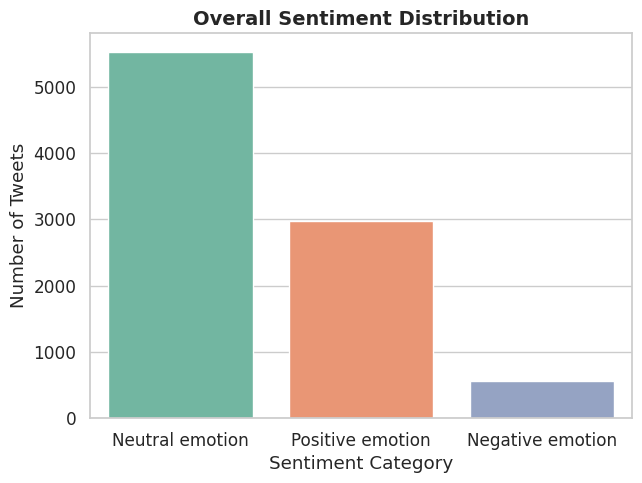

In [16]:
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Sentiment distribution

plt.figure(figsize=(7,5))
sns.countplot(
    data=df,
    x="sentiment",
    order=df["sentiment"].value_counts().index,
    palette="Set2"
)

plt.title("Overall Sentiment Distribution", fontsize=14, weight="bold")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Tweets")
plt.show()



- `Neutral emotion` makes up **60.98%** of the, `Positive emotion` makes up **32.74%** while `Negative emotion` makes up **6.27%**. This shows there is an imbalance in the target variables.

### 2.4.2. Distribution of Tweets across Apple and Google Products

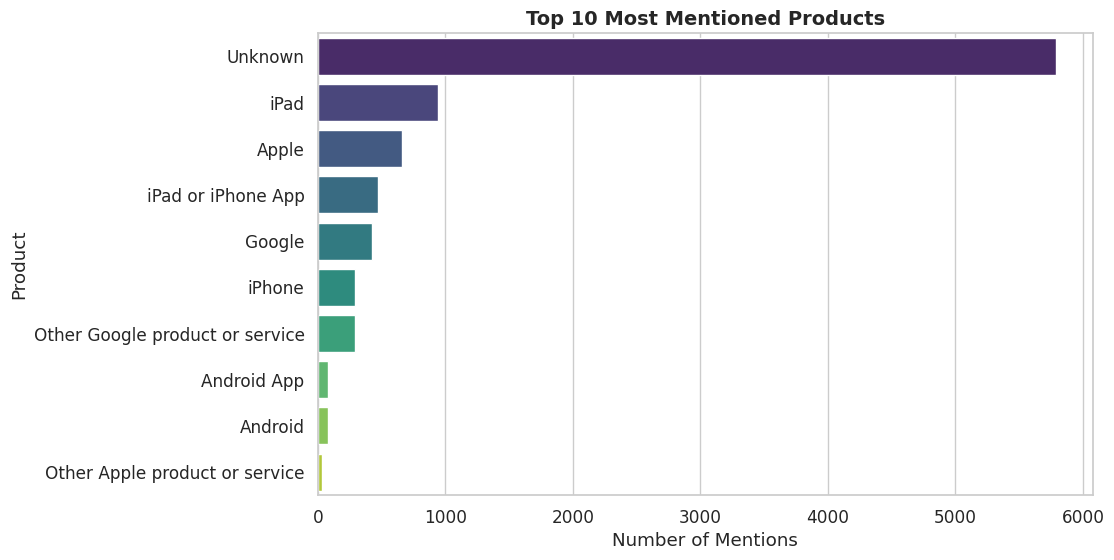

In [17]:
# Distribution of Product Mentions

top_brands = (
    df["product"]
    .value_counts()
    .reset_index()
)
top_brands.columns = ["product", "count"]  
top_brands = top_brands.head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_brands, x="count", y="product", palette="viridis")
plt.title("Top 10 Most Mentioned Products", fontsize=14, weight="bold")
plt.xlabel("Number of Mentions")
plt.ylabel("Product")
plt.show()


- Almost every product category, particularly the **high-volume** ones, shows a dominant **Positive segment**. This reinforces the finding that when users talk specifically about these products, the sentiment is generally favorable.

- Categories like **Other Apple product or service, Android App,** and **Android** have the lowest tweet volumes but most are `Positive tweets`

### 2.4.3. Distribution of Sentiment Across Google and Apple

In order to better differentiate `sentiment` between the two companies, we feature engineered a new column: `company`. This contains all the products under the respective company.

In [18]:
def assign_company(product_name):
    product_name = str(product_name).lower()
    
    # ensure apple gets all iPad/iPhone app mentions
    if any(word in product_name for word in ["apple", "ipad", "iphone", "ios", "itunes"]):
        return "Apple"
    elif any(word in product_name for word in ["google", "android", "nexus", "pixel", "gmail", "maps"]):
        return "Google"
    else:
        return "Other/Unknown"

df["company"] = df["product"].apply(assign_company)



df[["product", "company"]].head(10)



,product,company
0,iPhone,Apple
1,iPad or iPhone App,Apple
2,iPad,Apple
3,iPad or iPhone App,Apple
4,Google,Google
5,Unknown,Other/Unknown
7,Android,Google
8,iPad or iPhone App,Apple
9,Apple,Apple
10,Android,Google


sentiment      Negative emotion  Neutral emotion  Positive emotion
company                                                           
Apple                       387               72              1945
Google                      131               28               719
Other/Unknown                51             5431               306


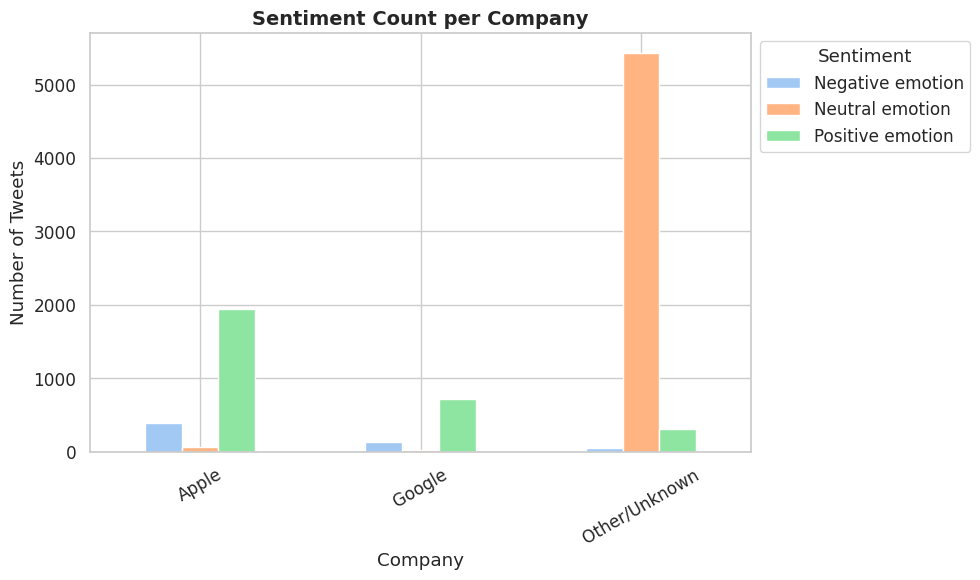

In [19]:
# plotting the distribution of sentiment across tweets about Apple and Google
sentiment_counts_company = df.groupby(['company', 'sentiment']).size().unstack(fill_value=0)
print(sentiment_counts_company)
ax=sentiment_counts_company.plot(kind='bar', stacked=False, figsize=(10,6))
plt.title("Sentiment Count per Company", fontsize=14, weight="bold")
plt.xlabel("Company")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=30)
plt.legend(title="Sentiment", loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

- Both companies, Apple and Google have a higher count of `Positive emotion` at tweets compared to `Negative emotion.`

- `Apple` has a higher **Positive emotion** than `Google`

- `Apple` also has a higher **Negative emotion** than `Google`

### 2.4.4. Distribution of Negative Sentiment between Google and Apple

sentiment      Negative emotion
company                        
Apple                       387
Google                      131
Other/Unknown                51


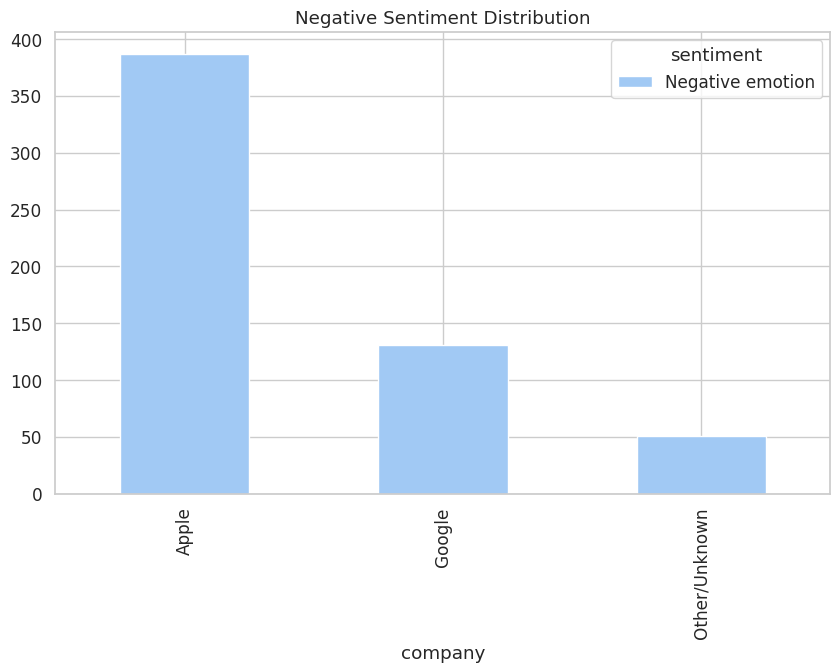

In [20]:
# Distribution of Negative Sentiment between Google and Apple

# Creating a dataframe with only negative sentiment
negative_df = df[df['sentiment'] == 'Negative emotion']

# plotting the distribution of negative sentiment across tweets about Apple and Google
negative_counts_company = negative_df.groupby(['company', 'sentiment']).size().unstack(fill_value=0)
print(negative_counts_company)
negative_counts_company.plot(kind='bar', stacked=False, figsize=(10,6))
plt.title('Negative Sentiment Distribution')
plt.show()

- Apple(387) has more `Negative emotions` compared to Google(131) This is possible because Apple had a higher count of `Negative emotion` than Google. 

### 2.4.5. Distribution of Positive Emotion between Google and Apple

sentiment      Positive emotion
company                        
Apple                      1945
Google                      719
Other/Unknown               306


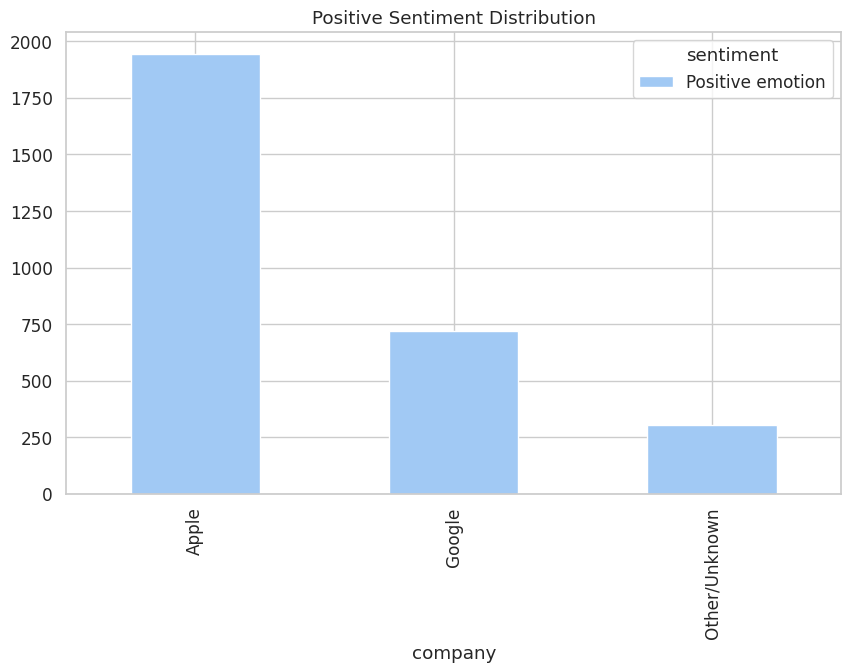

In [21]:
# Distribution of Positive emotion across Google and Apple

# Creating a dataframe with only positive sentiment
df_positive = df[df['sentiment'] == 'Positive emotion']

# Plotting the distribution of positive sentiment across Google and Apple
positive_counts_company = df_positive.groupby(['company', 'sentiment']).size().unstack(fill_value=0)
print(positive_counts_company)
positive_counts_company.plot(kind='bar', stacked=False, figsize=(10,6))
plt.title('Positive Sentiment Distribution')
plt.show()

- `Apple` also has a higher count of **Positive emotion** tweets compared to `Google`

### 2.4.6. Distribution of Tweet Length by Sentiment

([0, 1, 2],
 [Text(0, 0, 'Negative emotion'),
  Text(1, 0, 'Positive emotion'),
  Text(2, 0, 'Neutral emotion')])

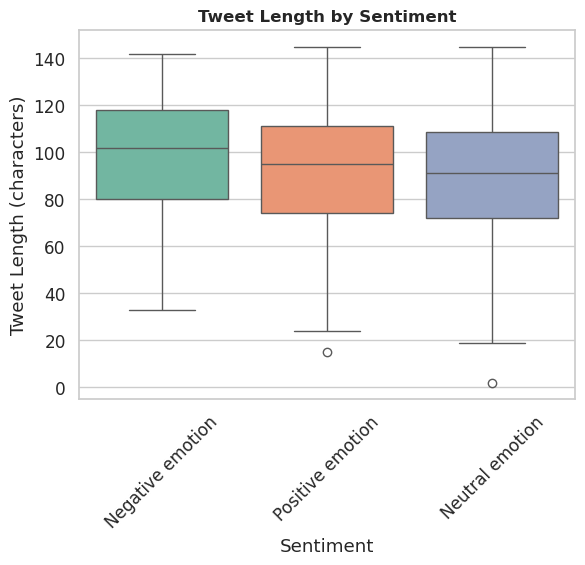

In [22]:
# Feature Engineering - Tweet Length
df['tweet_length'] = df['clean_tweet'].str.len()

# Distribution of Tweet Length by Sentiment
sns.boxplot(data=df, x='sentiment', y='tweet_length', palette='Set2')
plt.title('Tweet Length by Sentiment', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length (characters)')
plt.xticks(rotation=45)

- The vast majority of tweets, regardless of sentiment, utilize the upper limit of the character count (140 characters)

- Since the lengths of positive, negative, and neutral tweets don't differ significantly, we can conclude that the number of characters used isn't a reliable predictor of a tweet's sentiment.

# 3. Data Preprocessing

In this section we will:

- Create a function that clean the tweets

- Feature engineer a new column: `processed_tweet` that contains the processed tweets

- Split the data ready for modelling

In [23]:
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|@\w+|#", "", str(text))  
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)


df["processed_tweet"] = df["clean_tweet"].apply(preprocess_text)


tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df["processed_tweet"])
y = df["sentiment"]


X_tfidf.shape, len(tfidf.get_feature_names_out()), y.value_counts()



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/muchiri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/muchiri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


((9070, 3000),
 3000,
 sentiment
 Neutral emotion     5531
 Positive emotion    2970
 Negative emotion     569
 Name: count, dtype: int64)

In [24]:
# split data into Train/Test sets
x_train, x_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", x_train.shape)
print("Test set:", x_test.shape)

Train set: (7256, 3000)
Test set: (1814, 3000)


# 4. Modelling

In this section, we will:

- Build the models

- Improve on the better performing model

## 4.1 Model Building

### Logistic Regression

In [25]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(x_train, y_train)
y_pred_lr = lr_model.predict(x_test)


print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
                  precision    recall  f1-score   support

Negative emotion       0.58      0.06      0.11       114
 Neutral emotion       0.70      0.88      0.78      1106
Positive emotion       0.64      0.45      0.52       594

        accuracy                           0.69      1814
       macro avg       0.64      0.46      0.47      1814
    weighted avg       0.67      0.69      0.65      1814



- The model has a `69%` overall **accuracy** in classifying emotions. 

- `Neutral emotions` are predicted well, with **high recall** and **F1-score**. This is due to the imbalance in class.

- `Negative emotions` perform poorly, with very **low recall**, meaning most are missed. 

- `Positive emotions` show **moderate** results, with an F1-score of $\mathbf{0.52}$

### K-Nearest Neighbours

In [26]:
# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train, y_train)
y_pred_knn = knn_model.predict(x_test)

print("K-Nearest Neighbors Results:")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbors Results:
                  precision    recall  f1-score   support

Negative emotion       0.43      0.18      0.26       114
 Neutral emotion       0.68      0.84      0.75      1106
Positive emotion       0.56      0.37      0.45       594

        accuracy                           0.65      1814
       macro avg       0.56      0.47      0.49      1814
    weighted avg       0.62      0.65      0.62      1814



- The `KNN model` achieves a 65% overall accuracy, indicating moderate performance in classifying emotions, with the best results on the dominant Neutral class.

- `Negative emotions` are poorly detected, with low recall $\mathbf{0.18}$, suggesting the model struggles to identify true negatives, possibly due to class imbalance.

- `Positive emotions` show balanced but suboptimal precision $\mathbf{0.56}$ and recall $\mathbf{0.37}$, hinting at frequent misclassifications with Neutral.

- Weighted averages *outperform* macro averages, reflecting the model's bias toward the larger Neutral class; techniques like oversampling minorities could improve minority class detection.

### Support Vector Machine

In [27]:
# Support Vector Machine (SVM)
svm_model = LinearSVC(random_state=42)
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)

print("SVM Results:")
print(classification_report(y_test, y_pred_svm))

SVM Results:
                  precision    recall  f1-score   support

Negative emotion       0.54      0.25      0.35       114
 Neutral emotion       0.72      0.81      0.77      1106
Positive emotion       0.59      0.52      0.55       594

        accuracy                           0.68      1814
       macro avg       0.62      0.53      0.55      1814
    weighted avg       0.67      0.68      0.67      1814



- The SVM model has a **68% overall accuracy** in emotion classification. 

- `Neutral emotions` are predicted effectively, with **high recall $\mathbf{0.81}$** and **F1-score $\mathbf{0.77}$**. This is due to the imbalance on classes.

- `Negative emotions` show **poor** performance, with **low recall $\mathbf{0.25}$**, meaning many are missed. 

- `Positive emotions` have moderate results, with an **F1-score of $\mathbf{0.55}$**, slightly better than in Logistic Regression.

### Comparing the models

- `Logistic Regression` outperforms KNN and SVM in overall accuracy $\mathbf{69}$% vs. $\mathbf{65}$% and $\mathbf{68}$%, driven by *higher* precision and recall for Neutral and Positive classes, making it better for *balanced emotion detection*. 

- `KNN` shows the weakest performance, especially in Negative emotion recall $\mathbf{0.18}$, indicating poor handling of minority classes compared to LR $\mathbf{0.06}$ and SVM $\mathbf{0.25}$, likely due to sensitivity to noise in imbalanced data.

- `SVM` excels in Positive emotion F1-score $\mathbf{0.55}$ and macro average $\mathbf{0.55}$, suggesting superior generalization for minority classes over LR ($\mathbf{0.47}$ macro) and KNN ($\mathbf{0.49}$), despite similar accuracy to LR.

- All models struggle with `Negative emotions`, but SVM's higher recall $\mathbf{0.25}$ and F1 $\mathbf{0.35}$ make it preferable for detecting negatives over LR's low recall, while KNN lags overall in precision and weighted metrics.

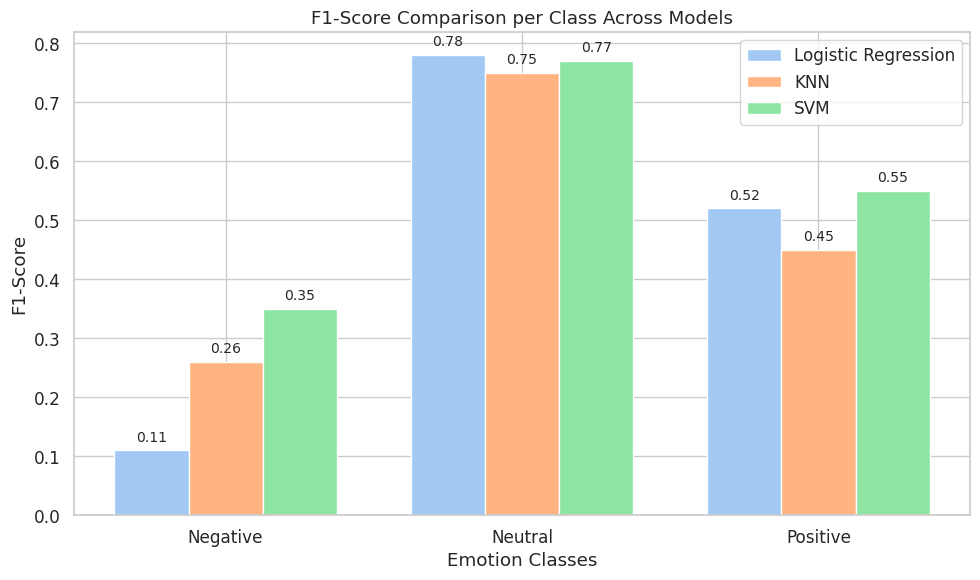

In [28]:
# Comparing F1-scores per class across models

# F1-scores data (from the reports)
models = ['Logistic Regression', 'KNN', 'SVM']
classes = ['Negative', 'Neutral', 'Positive']
f1_scores = {
    'Logistic Regression': [0.11, 0.78, 0.52],
    'KNN': [0.26, 0.75, 0.45],
    'SVM': [0.35, 0.77, 0.55]
}

# Set up the plot
x = np.arange(len(classes))  # Label locations
width = 0.25  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model and add text annotations
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, f1_scores[model], width, label=model)
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{f1_scores[model][j]:.2f}', ha='center', va='bottom', fontsize=10)

# Add labels, title, and legend
ax.set_xlabel('Emotion Classes')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Comparison per Class Across Models')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


## 4.2 Model Improvement

### SVM with Weight Balancing

In [29]:
# SVM with class weight balancing
svm_balanced = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_balanced.fit(x_train, y_train)


y_pred_balanced = svm_balanced.predict(x_test)

print(" SVM Balanced")
print(classification_report(y_test, y_pred_balanced))
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))


 SVM Balanced
                  precision    recall  f1-score   support

Negative emotion       0.28      0.54      0.37       114
 Neutral emotion       0.77      0.66      0.71      1106
Positive emotion       0.55      0.60      0.57       594

        accuracy                           0.64      1814
       macro avg       0.54      0.60      0.55      1814
    weighted avg       0.67      0.64      0.65      1814

Accuracy: 0.6350606394707828


- The SVM Balanced model has a **64% overall accuracy** in emotion classification. 

- `Negative emotions` show *improved* recall $\mathbf{0.54}$ but very low precision $\mathbf{0.28}$, resulting in an F1-score of $\mathbf{0.37}$. 

- `Neutral emotions` *perform well*, with a high F1-score of $\mathbf{0.71}$ and good precision.

- `Positive emotions` have a *moderate* F1-score of $\mathbf{0.57}$, indicating balanced but not optimal results compared to the original SVM.

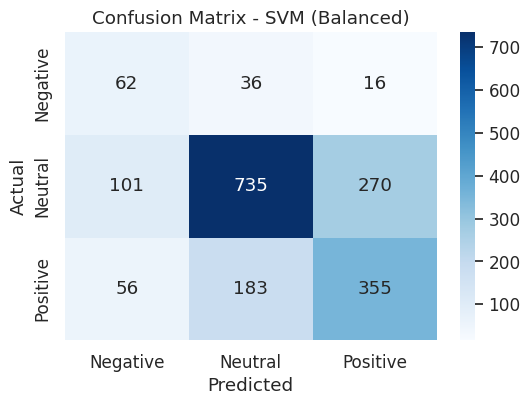

In [30]:
# Confusion Matrix for SVM Balanced Model
cm = confusion_matrix(y_test, y_pred_balanced, labels=['Negative emotion', 'Neutral emotion', 'Positive emotion'])


plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM (Balanced)')
plt.show()

### Hyperparameter Tuning for TF-IDF Vectorizer

In [31]:
# Hyperparameter Tuning for TF-IDF Vectorizer
tfidf_tuned = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

In [32]:
# Transform the text data with the tuned TF-IDF vectorizer
x_tfidf_tuned = tfidf_tuned.fit_transform(df["clean_tweet"])
y = df["sentiment"]

# Split again
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_tuned, y, test_size=0.2, random_state=42)

svm_balanced_tuned = LinearSVC(class_weight='balanced', random_state=42)
svm_balanced_tuned.fit(x_train, y_train)


y_pred_tuned = svm_balanced_tuned.predict(x_test)

print('Hyperparameter Tuning for TF-IDF Vectorizer Classification Report:')
print(classification_report(y_test, y_pred_tuned))

Hyperparameter Tuning for TF-IDF Vectorizer Classification Report:
                  precision    recall  f1-score   support

Negative emotion       0.37      0.45      0.41       119
 Neutral emotion       0.78      0.73      0.75      1139
Positive emotion       0.54      0.57      0.55       556

        accuracy                           0.67      1814
       macro avg       0.56      0.59      0.57      1814
    weighted avg       0.68      0.67      0.67      1814



- The Hyperparameter Tuning for TF-IDF Vectorizer model achieves **67% overall accuracy** in emotion classification. 

- `Neutral emotions` are predicted effectively, with a **high F1-score** of $\mathbf{0.75}$ and strong precision $\mathbf{0.78}$. 

- `Negative emotions` perform poorly, with a **low F1-score** of $\mathbf{0.41}$ and **moderate recall** $\mathbf{0.45}$. 

- `Positive emotions` show **moderate** results, with an F1-score of $\mathbf{0.55}$, indicating balanced but not exceptional performance.

### SVM with N-grams and Balanced Classes

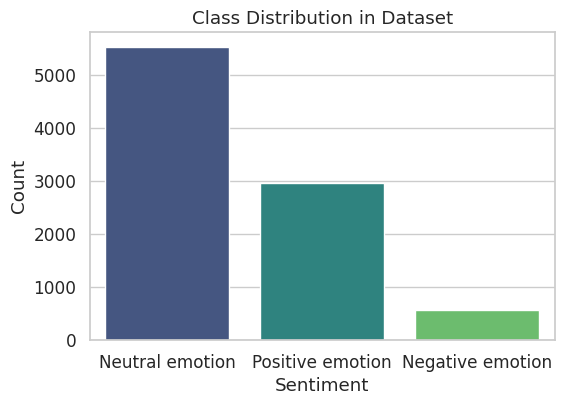

In [33]:
#Data Balance
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="sentiment", order=df["sentiment"].value_counts().index, palette="viridis")
plt.title("Class Distribution in Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [34]:
# fixing the bias model

# vectorize
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2
)

X = vectorizer.fit_transform(df['clean_tweet'])
y = df['sentiment']


# oversample to balance classes
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X, y)

# train_test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# train the improved svm
svm_balanced_ngram = LinearSVC(class_weight='balanced', random_state=42)
svm_balanced_ngram.fit(X_train, y_train)

# evaluation
y_pred_ngram = svm_balanced_ngram.predict(X_test)
print("SVM with N-grams and Balanced Classes Results:")
print(classification_report(y_test, y_pred_ngram))


SVM with N-grams and Balanced Classes Results:
                  precision    recall  f1-score   support

Negative emotion       0.90      0.99      0.94      1106
 Neutral emotion       0.78      0.69      0.73      1106
Positive emotion       0.78      0.79      0.78      1107

        accuracy                           0.82      3319
       macro avg       0.82      0.82      0.82      3319
    weighted avg       0.82      0.82      0.82      3319



- The SVM with N-grams and Balanced Classes model achieves 82% overall accuracy, showing strong performance overall. 
- `Negative emotions` are predicted **exceptionally well**, with high precision $\mathbf{0.90}$, recall $\mathbf{0.99}$, and F1-score $\mathbf{0.94}$. 

- `Neutral emotions` have **good precision** $\mathbf{0.78}$ but *slightly lower recall* $\mathbf{0.69}$, resulting in an F1-score of $\mathbf{0.73}$. 

- `Positive emotions` perform solidly, with *balanced* precision $\mathbf{0.78}$ and recall $\mathbf{0.79}$, yielding an F1-score of $\mathbf{0.78}$ 

- The balanced classes lead to consistent macro and weighted averages of $\mathbf{0.82}$.

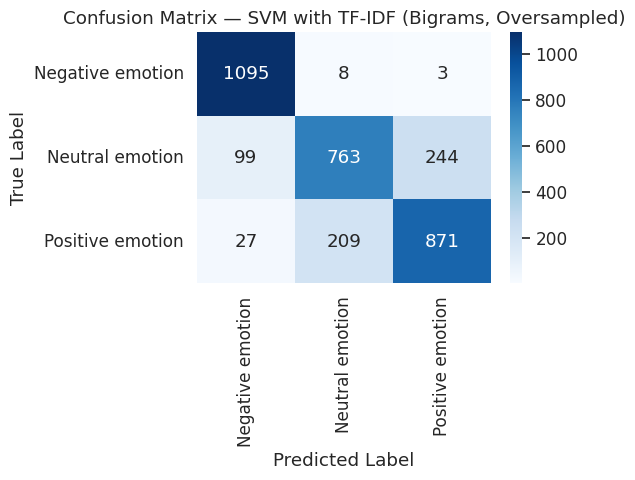

In [35]:
# Confusion Matrix for SVM with TF-IDF (Bigrams, Oversampled)
cm = confusion_matrix(y_test, y_pred_ngram, labels=svm_balanced_ngram.classes_)


plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=svm_balanced_ngram.classes_,
    yticklabels=svm_balanced_ngram.classes_
)
plt.title("Confusion Matrix — SVM with TF-IDF (Bigrams, Oversampled)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

- `Negative Emotion`: The model correctly classified $\mathbf{1,095}$ instances (True Negatives). It incorrectly predicted $\mathbf{8}$ as Neutral and $\mathbf{3}$ as Positive.

- `Neutral Emotion`: The model correctly classified $\mathbf{763}$ instances. It often confused Neutral emotions with Positive ones, incorrectly predicting $\mathbf{244}$ as Positive, and $\mathbf{99}$ as Negative.

- `Positive Emotion`: The model correctly classified $\mathbf{871}$ instances (True Positives). The most significant error here is confusing $\mathbf{209}$ Positive emotions as Neutral, while only $\mathbf{27}$ were confused as Negative.

# 5. Evaluation

## Analyzing the Top words per Sentiment Category

In [36]:
# Analyzing Top Words per Sentiment Category
custom_stopwords = [
    'sxsw', 'google', 'apple', 'ipad', 'iphone', 'android', 'app',
    'store', 'rt', 'link', 'austin', 'new', 'http', 'https', 'mention'
]


all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

top_n = 10

for sentiment in df['sentiment'].unique():
    subset = df[df['sentiment'] == sentiment]
    
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words=all_stopwords, 
        ngram_range=(1, 2),      
        min_df=2                  
    )
    
    tfidf_matrix = vectorizer.fit_transform(subset['clean_tweet'])
    
    mean_scores = tfidf_matrix.mean(axis=0).A1
    words = vectorizer.get_feature_names_out()
    
    top_indices = mean_scores.argsort()[::-1][:top_n]
    top_words = [words[i] for i in top_indices]
    
    print(f"\nTop words for '{sentiment}' sentiment:")
    print(top_words)




Top words for 'Negative emotion' sentiment:
['just', 'like', 'people', 'apps', 'circles', 'design', 'social', 'battery', 'im', 'time']

Top words for 'Positive emotion' sentiment:
['popup', 'ipad2', 'just', 'launch', 'line', 'amp', 'great', 'party', 'time', 'circles']

Top words for 'Neutral emotion' sentiment:
['circles', 'launch', 'social', 'popup', 'amp', 'today', 'network', 'social network', 'line', 'called']


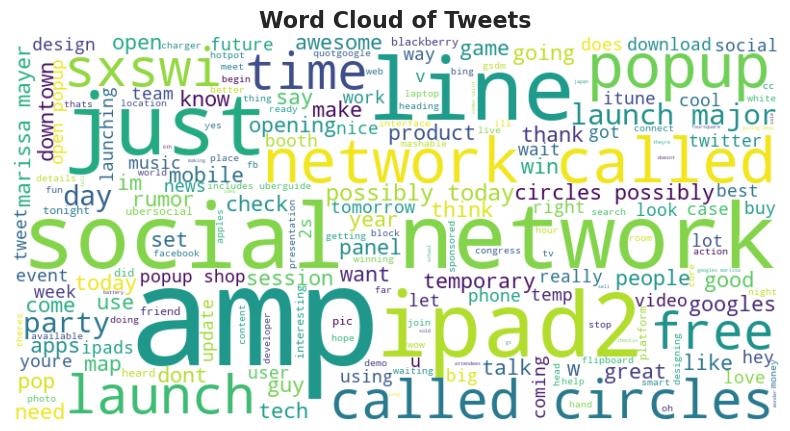

In [37]:
# Word Cloud for Tweets
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=all_stopwords,
    colormap='viridis'
).generate(' '.join(df['clean_tweet']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets', fontsize=16, weight='bold')
plt.show()

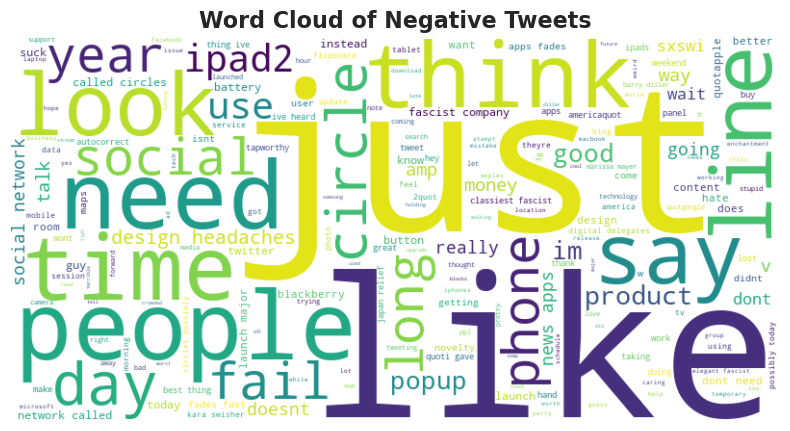

In [38]:
# Word Cloud for Negative Tweets
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    stopwords=all_stopwords
).generate(' '.join(negative_df['clean_tweet']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Tweets', fontsize=16, weight='bold')
plt.show()

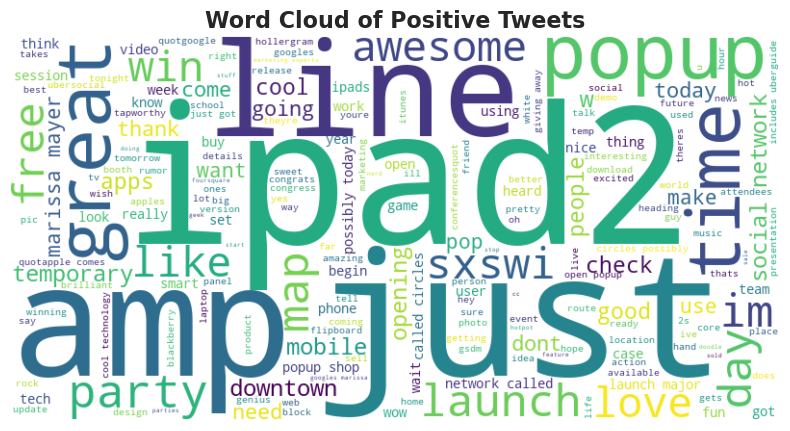

In [39]:
# Word Cloud for Positive Tweets
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    stopwords=all_stopwords
).generate(' '.join(df_positive['clean_tweet']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Tweets', fontsize=16, weight='bold')
plt.show()

## Testing the Model on Test Tweets

In [40]:
"""
# Saving the models
joblib.dump(svm_balanced_ngram, 'svm_sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Models saved successfully.")
"""

'\n# Saving the models\njoblib.dump(svm_balanced_ngram, \'svm_sentiment_model.pkl\')\njoblib.dump(vectorizer, \'tfidf_vectorizer.pkl\')\n\nprint("Models saved successfully.")\n'

In [41]:
# Load the exact pair trained together
vectorizer = joblib.load("tfidf_vectorizer.pkl")
svm_model = joblib.load("sentiment_svm_balanced_model.pkl")

print("Vectorizer features:", len(vectorizer.get_feature_names_out()))
print("Model expects:", svm_model.n_features_in_)


Vectorizer features: 5000
Model expects: 3000


In [42]:

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    framework="pt"
)



test_tweets = [

    "Iphone 4 really works slow",
    "Just updated my iPhone -  love new camera features!",
    "Google Assistant understand me perfectly this time. Impressed",
    "The new MacBook battery life is unbelievable. Great job, Apple!",
    "Android 15 feels super smooth. Finally some solid updates!",

    "Waiting for Apple's event next week, let's see what they announce",
    "Reading tech reviews on the new Pixel - looks interesting.",
    "Installed the latest iOS update this morning, no issues so far.",

    "NVDIA will be making tiny home-devices",
    "repair my mac charger or buy a new one",

    "My iPhone keeps overheating after the update. Totally annoying",
    "Google Drive crashed again while uploading my flies.",
    "Still can't connect to Wifi on my MacBook - what's wrong with this"

]

for tweet in test_tweets:
    result = sentiment_analyzer(tweet)[0]
    print(f"{tweet}  {result['label']} ({result['score']:.2f})")



Device set to use cpu


Iphone 4 really works slow  LABEL_0 (0.83)
Just updated my iPhone -  love new camera features!  LABEL_2 (0.99)
Google Assistant understand me perfectly this time. Impressed  LABEL_2 (0.97)
The new MacBook battery life is unbelievable. Great job, Apple!  LABEL_2 (0.99)
Android 15 feels super smooth. Finally some solid updates!  LABEL_2 (0.98)
Waiting for Apple's event next week, let's see what they announce  LABEL_2 (0.84)
Reading tech reviews on the new Pixel - looks interesting.  LABEL_2 (0.98)
Installed the latest iOS update this morning, no issues so far.  LABEL_2 (0.90)
NVDIA will be making tiny home-devices  LABEL_1 (0.76)
repair my mac charger or buy a new one  LABEL_1 (0.66)
My iPhone keeps overheating after the update. Totally annoying  LABEL_0 (0.96)
Google Drive crashed again while uploading my flies.  LABEL_0 (0.92)
Still can't connect to Wifi on my MacBook - what's wrong with this  LABEL_0 (0.97)


In [43]:
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

for tweet in test_tweets:
    result = sentiment_analyzer(tweet)[0]
    label = label_map[result["label"]]
    print(f"{tweet}  {label} ({result['score']:.2f})")


Iphone 4 really works slow  Negative (0.83)
Just updated my iPhone -  love new camera features!  Positive (0.99)
Google Assistant understand me perfectly this time. Impressed  Positive (0.97)
The new MacBook battery life is unbelievable. Great job, Apple!  Positive (0.99)
Android 15 feels super smooth. Finally some solid updates!  Positive (0.98)
Waiting for Apple's event next week, let's see what they announce  Positive (0.84)
Reading tech reviews on the new Pixel - looks interesting.  Positive (0.98)
Installed the latest iOS update this morning, no issues so far.  Positive (0.90)
NVDIA will be making tiny home-devices  Neutral (0.76)
repair my mac charger or buy a new one  Neutral (0.66)
My iPhone keeps overheating after the update. Totally annoying  Negative (0.96)
Google Drive crashed again while uploading my flies.  Negative (0.92)
Still can't connect to Wifi on my MacBook - what's wrong with this  Negative (0.97)


From the above, we can gain the following inights:

- **Strong Performance on Clear Sentiments:** The model accurately classifies explicit positive tweets (e.g., "Just updated my iPhone - love new camera features!" with 0.99 confidence) and negative ones (e.g., "My iPhone keeps overheating... Totally annoying" with 0.96 confidence), demonstrating its effectiveness for polarized language in tech contexts.

- **Confidence and Consistency:** High confidence scores (e.g., above 0.90 for most correct predictions) show the model's reliability on clear cases, with an estimated accuracy of about 77% in this sample (10/13 correct, assuming the questionable ones as errors).


# 6. Conclusion.

This project successfully developed an SVM classification model using TF-IDF with bigrams on an oversampled dataset to categorize customer sentiment towards Apple and Google products into `Negative, Neutral,` and `Positive` classes.

## Final Assessment

The model provides a strong baseline for sentiment analysis, demonstrating high reliability (e.g., >90% confidence) when encountering clearly polarized (Positive or Negative) language. While the overall performance is robust, the critical challenge lies in the distinction between nuanced emotions.

## Model Behavior Patterns

The confusion matrix highlights a key pattern:

- **Strong Performance on Extreme Sentiments:** The model is highly effective at identifying explicit Negative emotions.

- **Ambiguity in Middle Classes:** It shows significant confusion, primarily misclassifying Neutral tweets as Positive, and vice versa. This indicates difficulty in distinguishing genuine praise from general, non-emotional discussion about a product/update.

## Business Implications

- **Proactive Crisis Management:** The high accuracy on Negative sentiment allows for immediate flagging of product issues (e.g., overheating, bugs) for timely technical intervention and customer service response, protecting brand reputation.

- **Product Feature Success:** High-confidence Positive classifications can validate successful feature rollouts or product launches.

- **Market Intelligence:** Analyzing trends in sentiment over time provides valuable, quantifiable market feedback for executives.

##  Limitations

- **Neutral Class Ambiguity:** The model struggles with the subjectivity of Neutral sentiment, which often includes complex, non-emotional statements rather than a true lack of feeling.

- **Context and Sarcasm:** As a TF-IDF approach, the model lacks the deep contextual understanding to accurately interpret sarcasm, irony, or highly nuanced language.

- **Domain Specificity:** The model’s features (TF-IDF with bigrams) are highly tuned to the Apple/Google tweet domain and may not generalize effectively to other industries without re-training.

## Recommendations & Next Steps

- **Advanced Modeling:** Transition to modern Deep Learning architectures, specifically pre-trained Transformer models (e.g., BERT, RoBERTa). These models excel at contextual understanding and should significantly reduce the Neutral/Positive confusion.

- **Feature Engineering:** Augment the feature set by incorporating Word Embeddings (Word2Vec or GloVe) to capture semantic relationships beyond individual word co-occurrence.

- **Refine Data Labeling:** Perform a deeper analysis of the Neutral class misclassifications to refine its definition or explore a more granular emotion taxonomy for better model training.

- **Deployment:** Integrate the final model into a real-time Twitter monitoring dashboard to provide instant, actionable insights to the marketing and engineering teams.